In [1]:
import numpy as np
import pandas as pd

In [2]:
curr = "CARD"
df_timestamp = "20250615_014502"

CARD_df = pd.read_json(f'../market-data/{curr}/{curr}_{df_timestamp}_1st_round.json', orient='index')

In [3]:
CARD_df.head()

,open,close,high,low,mid,index
1095,100293,100183,100349,100091,100258,0
2095,99511,99441,99596,99342,99484,1
3095,98846,98817,98897,98764,98844,2
4095,99509,99433,99553,99244,99484,3
5095,100118,100137,100337,100105,100129,4


In [4]:
# structure & null‐counts
CARD_df.info()

# rows × columns
print("Shape:", CARD_df.shape)

# summary statistics
CARD_df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 1809 entries, 1095 to 1809095
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   open    1809 non-null   int64
 1   close   1809 non-null   int64
 2   high    1809 non-null   int64
 3   low     1809 non-null   int64
 4   mid     1809 non-null   int64
 5   index   1809 non-null   int64
dtypes: int64(6)
memory usage: 98.9 KB
Shape: (1809, 6)


,open,close,high,low,mid,index
count,1809.000000,1809.000000,1809.000000,1809.000000,1809.000000,1809.000000
mean,100227.846877,100227.044223,100400.632946,100085.417910,100244.609729,904.000000
std,1282.768008,1277.977390,1286.200075,1279.366355,1279.416217,522.357636
min,96139.000000,96209.000000,96402.000000,96113.000000,96201.000000,0.000000
25%,99325.000000,99331.000000,99475.000000,99191.000000,99356.000000,452.000000
50%,100141.000000,100154.000000,100329.000000,100026.000000,100129.000000,904.000000
75%,101120.000000,101082.000000,101307.000000,100947.000000,101168.000000,1356.000000
max,103930.000000,104135.000000,104938.000000,103888.000000,104083.000000,1808.000000


/home/gerard/Programació/Hackathons/AlgoTrade-2025/venv-algotrade/lib/python3.12/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


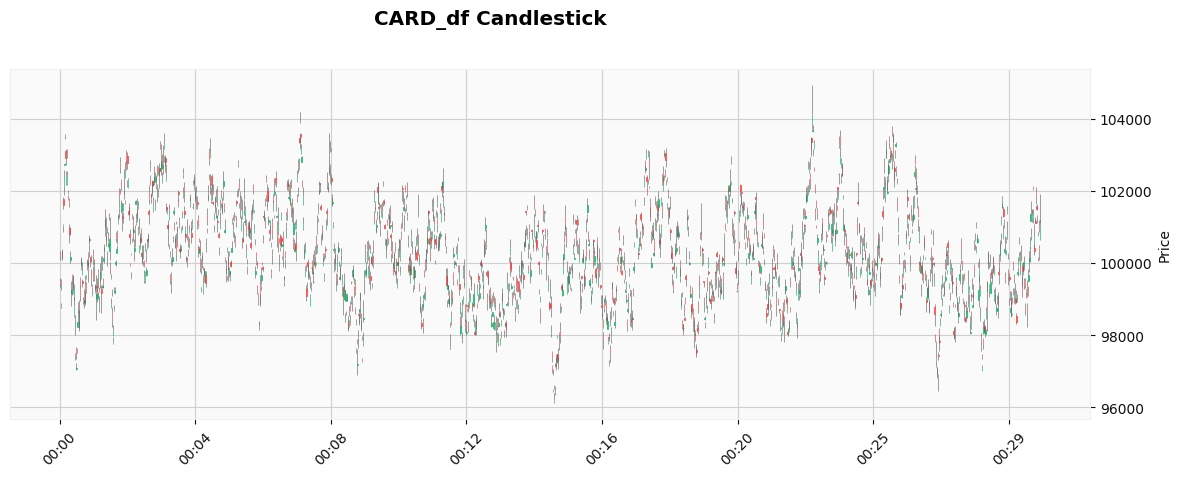

In [5]:
import mplfinance as mpf

# ensure datetime‐index
CARD_df.index = pd.to_datetime(CARD_df.index, unit='ms')

# wider candlestick
mpf.plot(
    CARD_df[['open','high','low','close']],
    type='candle',
    style='yahoo',
    title='CARD_df Candlestick',
    ylabel='Price',
    figsize=(15, 5)   # width=15, height=6 inches
)

# All of the currencies toghether: (FOR THE 1ST RANKED ROW)

In [6]:
CURRENCIES = ["CARD", "GARR", "HEST", "JUMP", "LOGN", "SIMP"] # Assuming 6
BASE_PATH = '../market-data/'

first_ranked_timestamp = "20250615_014502"


In [7]:
data = dict()
for curr in CURRENCIES:
    curr_df = pd.read_json(f'../market-data/{curr}/{curr}_{first_ranked_timestamp}_1st_round.json', orient='index')
    curr_df['curr'] = curr
    data[curr] = curr_df

data['CARD'].head()

,open,close,high,low,mid,index,curr
1095,100293,100183,100349,100091,100258,0,CARD
2095,99511,99441,99596,99342,99484,1,CARD
3095,98846,98817,98897,98764,98844,2,CARD
4095,99509,99433,99553,99244,99484,3,CARD
5095,100118,100137,100337,100105,100129,4,CARD


In [8]:
import pandas as pd

def create_all_features(df: pd.DataFrame) -> None:
    """
    Creates a comprehensive and advanced set of features for a time-series model.
    """
    # --- Part 1: Intraday Features ---
    df['body'] = df['close'] - df['open']
    df['range'] = df['high'] - df['low']
    df['body_pct'] = df['body'] / (df['range'] + 1e-6)

    # --- NEW ADDITION 1: Asymmetric Volatility (Wicks) ---
    df['upper_wick'] = df['high'] - df[['open', 'close']].max(axis=1)
    df['lower_wick'] = df[['open', 'close']].min(axis=1) - df['low']
    df['upper_wick_pct'] = df['upper_wick'] / (df['range'] + 1e-6)
    df['lower_wick_pct'] = df['lower_wick'] / (df['range'] + 1e-6)

    # --- Part 2: Lag Features (Specific Memory) ---
    lags_to_create = [1, 2, 3, 5, 7, 10]
    columns_to_lag = ['mid', 'range', 'body_pct'] 
    for col in columns_to_lag:
        for lag in lags_to_create:
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)

    # --- Part 3: Trend Features (Summarized Context) ---
    windows = [3, 6, 12, 25, 50, 100, 200, 400]
    features_to_average = ['close', 'range', 'body_pct']
    for col in features_to_average:
        for w in windows:
            df[f'{col}_sma_{w}'] = df[col].rolling(window=w).mean()
            df[f'{col}_ema_{w}'] = df[col].ewm(span=w, adjust=False).mean()

    # --- Part 4: Trend-Relative Features ---
    for w in windows:
        df[f'close_div_ema_{w}'] = df['close'] / (df[f'close_ema_{w}'] + 1e-6)

    # --- Part 5: Volatility of Volatility ---
    vol_windows = [12, 25, 50]
    for w in vol_windows:
        df[f'range_std_{w}'] = df['range'].rolling(window=w).std()

    # --- Part 6: Momentum Acceleration (MACD) ---
    ema_fast = df['close'].ewm(span=12, adjust=False).mean()
    ema_slow = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema_fast - ema_slow
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']

    # --- Part 7: Time-Based Features ---
    df['time'] = df.index
    df = df.set_index('index', drop=False, inplace=True)

In [9]:
for curr in CURRENCIES:
    create_all_features(data[curr])

In [10]:
print(data['CARD'].columns)
data['CARD'].head()


Index(['open', 'close', 'high', 'low', 'mid', 'index', 'curr', 'body', 'range',
       'body_pct', 'upper_wick', 'lower_wick', 'upper_wick_pct',
       'lower_wick_pct', 'mid_lag_1', 'mid_lag_2', 'mid_lag_3', 'mid_lag_5',
       'mid_lag_7', 'mid_lag_10', 'range_lag_1', 'range_lag_2', 'range_lag_3',
       'range_lag_5', 'range_lag_7', 'range_lag_10', 'body_pct_lag_1',
       'body_pct_lag_2', 'body_pct_lag_3', 'body_pct_lag_5', 'body_pct_lag_7',
       'body_pct_lag_10', 'close_sma_3', 'close_ema_3', 'close_sma_6',
       'close_ema_6', 'close_sma_12', 'close_ema_12', 'close_sma_25',
       'close_ema_25', 'close_sma_50', 'close_ema_50', 'close_sma_100',
       'close_ema_100', 'close_sma_200', 'close_ema_200', 'close_sma_400',
       'close_ema_400', 'range_sma_3', 'range_ema_3', 'range_sma_6',
       'range_ema_6', 'range_sma_12', 'range_ema_12', 'range_sma_25',
       'range_ema_25', 'range_sma_50', 'range_ema_50', 'range_sma_100',
       'range_ema_100', 'range_sma_200', 'range_em

,open,close,high,low,mid,index,curr,body,range,body_pct,...,close_div_ema_100,close_div_ema_200,close_div_ema_400,range_std_12,range_std_25,range_std_50,macd,macd_signal,macd_hist,time
index,,,,,,,,,,,,,,,,,,,,,
0,100293,100183,100349,100091,100258,0,CARD,-110,258,-0.426357,...,1.000000,1.000000,1.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,1095
1,99511,99441,99596,99342,99484,1,CARD,-70,254,-0.275591,...,0.992739,0.992667,0.992630,NaN,NaN,NaN,-59.190883,-11.838177,-47.352707,2095
2,98846,98817,98897,98764,98844,2,CARD,-29,133,-0.218045,...,0.986773,0.986571,0.986468,NaN,NaN,NaN,-154.668745,-40.404290,-114.264454,3095
3,99509,99433,99553,99244,99484,3,CARD,-76,309,-0.245955,...,0.993064,0.992793,0.992654,NaN,NaN,NaN,-178.571129,-68.037658,-110.533471,4095
4,100118,100137,100337,100105,100129,4,CARD,19,232,0.081897,...,1.000093,0.999824,0.999684,NaN,NaN,NaN,-139.103525,-82.250831,-56.852694,5095


In [11]:
import pandas as pd
import glob

In [12]:
files_by_currency = {}

for curr in CURRENCIES:
    # Use glob to find ALL .json files in the currency's directory.
    # This will naturally include '1st_ranked_round...' and all others like 'CARD_...'.
    all_files = glob.glob(f'{BASE_PATH}{curr}/*.json')

    # Sort the list of files. This works correctly because your timestamp
    # format YYYYMMDD_HHMMSS is lexicographically sortable.
    all_files.sort()

    files_by_currency[curr] = all_files

In [13]:
# --- Let's verify the result ---
print("Discovered and sorted the following files:")
for curr, files in files_by_currency.items():
    print(f"\n--- Currency: {curr} ---")
    if files:
        print(f"  Found {len(files)} files.")
        print(f"  First file: {files[0]}")
        print(f"  Last file:  {files[-1]}")
    else:
        print("  No files found.")

Discovered and sorted the following files:

--- Currency: CARD ---
  Found 11 files.
  First file: ../market-data/CARD/CARD_20250615_014502_1st_round.json
  Last file:  ../market-data/CARD/CARD_20250615_071322.json

--- Currency: GARR ---
  Found 11 files.
  First file: ../market-data/GARR/GARR_20250615_014502_1st_round.json
  Last file:  ../market-data/GARR/GARR_20250615_071322.json

--- Currency: HEST ---
  Found 11 files.
  First file: ../market-data/HEST/HEST_20250615_014502_1st_round.json
  Last file:  ../market-data/HEST/HEST_20250615_071322.json

--- Currency: JUMP ---
  Found 11 files.
  First file: ../market-data/JUMP/JUMP_20250615_014502_1st_round.json
  Last file:  ../market-data/JUMP/JUMP_20250615_071322.json

--- Currency: LOGN ---
  Found 11 files.
  First file: ../market-data/LOGN/LOGN_20250615_014502_1st_round.json
  Last file:  ../market-data/LOGN/LOGN_20250615_071322.json

--- Currency: SIMP ---
  Found 11 files.
  First file: ../market-data/SIMP/SIMP_20250615_014502_

## Add timeframe for predictions

In [14]:
def get_dynamic_target_timestamps(t_now: int, n_targets: int = 4, interval: int = 15) -> list[int]:
    """Calculates the nearest future n_targets that are multiples of the interval."""
    first_target = ((t_now // interval) + 1) * interval
    targets = [first_target + i * interval for i in range(n_targets)]
    return targets

In [15]:
def add_timeframe_prediction_columns(df: pd.DataFrame) -> pd.DataFrame:
    
    close_price_map = df['close'].to_dict()

    all_new_rows = []
    
    for t_now, original_row in df.iterrows():
        
        target_timestamps = get_dynamic_target_timestamps(t_now)

        for T_target in target_timestamps:
            
            target_price = close_price_map.get(T_target)

            if target_price is None:
                continue

            new_row = original_row.to_dict()
            new_row['forecast_horizon'] = T_target - t_now
            new_row['target'] = target_price
            
            all_new_rows.append(new_row)

    # --- Step 3: Create the final DataFrame ---
    
    # Create the final, long-format DataFrame from our list of rows.
    # This is much more memory-efficient than appending to a DataFrame in a loop.
    final_df = pd.DataFrame(all_new_rows)
    
    # It's good practice to explicitly set the order of columns for clarity.
    # We move the new, important columns to the front.
    cols_to_move = ['index', 'forecast_horizon', 'target']
    all_cols = cols_to_move + [col for col in final_df.columns if col not in cols_to_move]
    
    return final_df[all_cols]

In [16]:
df = data['CARD']
df.head()

,open,close,high,low,mid,index,curr,body,range,body_pct,...,close_div_ema_100,close_div_ema_200,close_div_ema_400,range_std_12,range_std_25,range_std_50,macd,macd_signal,macd_hist,time
index,,,,,,,,,,,,,,,,,,,,,
0,100293,100183,100349,100091,100258,0,CARD,-110,258,-0.426357,...,1.000000,1.000000,1.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,1095
1,99511,99441,99596,99342,99484,1,CARD,-70,254,-0.275591,...,0.992739,0.992667,0.992630,NaN,NaN,NaN,-59.190883,-11.838177,-47.352707,2095
2,98846,98817,98897,98764,98844,2,CARD,-29,133,-0.218045,...,0.986773,0.986571,0.986468,NaN,NaN,NaN,-154.668745,-40.404290,-114.264454,3095
3,99509,99433,99553,99244,99484,3,CARD,-76,309,-0.245955,...,0.993064,0.992793,0.992654,NaN,NaN,NaN,-178.571129,-68.037658,-110.533471,4095
4,100118,100137,100337,100105,100129,4,CARD,19,232,0.081897,...,1.000093,0.999824,0.999684,NaN,NaN,NaN,-139.103525,-82.250831,-56.852694,5095


In [17]:
new_df = add_timeframe_prediction_columns(df)

In [18]:
new_df

,index,forecast_horizon,target,open,close,high,low,mid,curr,body,...,close_div_ema_100,close_div_ema_200,close_div_ema_400,range_std_12,range_std_25,range_std_50,macd,macd_signal,macd_hist,time
0,0,15,101971,100293,100183,100349,100091,100258,CARD,-110,...,1.000000,1.000000,1.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,1095
1,0,30,97550,100293,100183,100349,100091,100258,CARD,-110,...,1.000000,1.000000,1.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,1095
2,0,45,98961,100293,100183,100349,100091,100258,CARD,-110,...,1.000000,1.000000,1.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,1095
3,0,60,99346,100293,100183,100349,100091,100258,CARD,-110,...,1.000000,1.000000,1.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,1095
4,1,14,101971,99511,99441,99596,99342,99484,CARD,-70,...,0.992739,0.992667,0.992630,NaN,NaN,NaN,-59.190883,-11.838177,-47.352707,2095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7105,1795,5,101903,101222,101305,101514,101107,101299,CARD,83,...,1.015182,1.015460,1.014018,154.790083,175.519704,161.745051,516.808562,299.477958,217.330604,1796095
7106,1796,4,101903,100500,100728,101091,100421,100647,CARD,228,...,1.009212,1.009579,1.008201,178.407773,185.505274,168.254986,472.641852,334.110737,138.531115,1797094
7107,1797,3,101903,100406,100324,100537,100225,100388,CARD,-82,...,1.005061,1.005475,1.004136,177.410391,185.090518,166.585259,400.424151,347.373420,53.050731,1798095
7108,1798,2,101903,101147,101171,101275,101101,101168,CARD,24,...,1.013275,1.013823,1.012550,186.107659,178.805649,166.283559,406.847046,359.268145,47.578901,1799095


In [19]:
df.head()

,open,close,high,low,mid,index,curr,body,range,body_pct,...,close_div_ema_100,close_div_ema_200,close_div_ema_400,range_std_12,range_std_25,range_std_50,macd,macd_signal,macd_hist,time
index,,,,,,,,,,,,,,,,,,,,,
0,100293,100183,100349,100091,100258,0,CARD,-110,258,-0.426357,...,1.000000,1.000000,1.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,1095
1,99511,99441,99596,99342,99484,1,CARD,-70,254,-0.275591,...,0.992739,0.992667,0.992630,NaN,NaN,NaN,-59.190883,-11.838177,-47.352707,2095
2,98846,98817,98897,98764,98844,2,CARD,-29,133,-0.218045,...,0.986773,0.986571,0.986468,NaN,NaN,NaN,-154.668745,-40.404290,-114.264454,3095
3,99509,99433,99553,99244,99484,3,CARD,-76,309,-0.245955,...,0.993064,0.992793,0.992654,NaN,NaN,NaN,-178.571129,-68.037658,-110.533471,4095
4,100118,100137,100337,100105,100129,4,CARD,19,232,0.081897,...,1.000093,0.999824,0.999684,NaN,NaN,NaN,-139.103525,-82.250831,-56.852694,5095


In [20]:
all_master_datasets = {}

for currency, sorted_files in files_by_currency.items():
    print("\n"+'='*20 + f"\nProcessing currency: {currency}\n"+'='*20)
    
    list_of_processed_files = []

    for i, file_path in enumerate(sorted_files):
        print(f"  - ({i+1}/{len(sorted_files)}) Processing file: {file_path.split('/')[-1]}...")
        
        try:
            # Step 1: LOAD data for this single file.
            df_file = pd.read_json(file_path, orient='index')
            if df_file.empty:
                print("      -> File is empty. Skipping.")
                continue
            df_file.sort_index(inplace=True)
            df_file['curr'] = currency
            
            # Step 2: CREATE BASE FEATURES for this file only.
            create_all_features(df_file)

            # Step 3: STACK the data to create the 4 prediction rows for each original row.
            df_file = add_timeframe_prediction_columns(df_file)
            
            # Append the fully processed DataFrame to our list for this currency.
            list_of_processed_files.append(df_file)

        except Exception as e:
            print(f"      -> ERROR processing file {file_path}: {e}")
            continue

    # Step 4: COMBINE all processed files for the current currency into one master DataFrame.
    if list_of_processed_files:
        master_df = pd.concat(list_of_processed_files, ignore_index=True)
        
        # Final cleanup: drop any rows that have NaN values from feature calculations
        initial_rows = len(master_df)
        master_df.dropna(inplace=True)
        final_rows = len(master_df)
        
        all_master_datasets[currency] = master_df
        
        print(f"\n--- Finished {currency} ---")
        print(f"  - Master dataset created with {final_rows:,} rows.")
        print(f"  - Dropped {initial_rows - final_rows:,} rows with NaN values.")

print("\n\n"+ '='*50 + "\n Master Dataset Creation Complete! \n" + '='*50 )


Processing currency: CARD
  - (1/11) Processing file: CARD_20250615_014502_1st_round.json...
  - (2/11) Processing file: CARD_20250615_022144.json...
  - (3/11) Processing file: CARD_20250615_025824.json...
  - (4/11) Processing file: CARD_20250615_032944.json...
  - (5/11) Processing file: CARD_20250615_040555.json...
  - (6/11) Processing file: CARD_20250615_043615.json...
  - (7/11) Processing file: CARD_20250615_051052.json...
  - (8/11) Processing file: CARD_20250615_054143.json...
  - (9/11) Processing file: CARD_20250615_060000.json...
  - (10/11) Processing file: CARD_20250615_063621.json...
  - (11/11) Processing file: CARD_20250615_071322.json...

--- Finished CARD ---
  - Master dataset created with 44,649 rows.
  - Dropped 16,404 rows with NaN values.

Processing currency: GARR
  - (1/11) Processing file: GARR_20250615_014502_1st_round.json...
  - (2/11) Processing file: GARR_20250615_022144.json...
  - (3/11) Processing file: GARR_20250615_025824.json...
  - (4/11) Proces

In [21]:
# ==============================================================================
#  Phase 3: Verification
# ==============================================================================
print("\nVerifying the structure of the generated datasets...")

# Let's inspect the result for one currency to confirm it's correct.
if "CARD" in all_master_datasets:
    card_master_df = all_master_datasets["CARD"]
    print("\n--- Inspection of 'CARD' Master Dataset ---")
    print(f"Shape of the dataset (rows, columns): {card_master_df.shape}")
    
    print("\nFirst 5 rows:")
    # Displaying a curated list of columns for better readability
    display_cols = ['time_index', 'forecast_horizon', 'target', 'close', 'mid', 'body_pct', 'close_ema_50']
    # Ensure all display columns exist before trying to show them
    display_cols = [col for col in display_cols if col in card_master_df.columns]
    print(card_master_df[display_cols].head())

    print("\nDataset Info (memory usage, data types):")
    card_master_df.info(memory_usage='deep')
else:
    print("\nCould not find 'CARD' dataset to inspect. Please check the processing logs.")



Verifying the structure of the generated datasets...

--- Inspection of 'CARD' Master Dataset ---
Shape of the dataset (rows, columns): (44649, 97)

First 5 rows:
      forecast_horizon  target   close     mid  body_pct   close_ema_50
1596                 6   99883  101671  101692 -0.063395  100979.736668
1597                21  102142  101671  101692 -0.063395  100979.736668
1598                36  100397  101671  101692 -0.063395  100979.736668
1599                51  100314  101671  101692 -0.063395  100979.736668
1600                 5   99883  101307  101299  0.414634  100992.570524

Dataset Info (memory usage, data types):
<class 'pandas.core.frame.DataFrame'>
Index: 44649 entries, 1596 to 61052
Data columns (total 97 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              44649 non-null  int64  
 1   forecast_horizon   44649 non-null  int64  
 2   target             44649 non-null  int64  
 3   open      

In [22]:
card_master_df = all_master_datasets["CARD"]
card_master_df.columns

Index(['index', 'forecast_horizon', 'target', 'open', 'close', 'high', 'low',
       'mid', 'curr', 'body', 'range', 'body_pct', 'upper_wick', 'lower_wick',
       'upper_wick_pct', 'lower_wick_pct', 'mid_lag_1', 'mid_lag_2',
       'mid_lag_3', 'mid_lag_5', 'mid_lag_7', 'mid_lag_10', 'range_lag_1',
       'range_lag_2', 'range_lag_3', 'range_lag_5', 'range_lag_7',
       'range_lag_10', 'body_pct_lag_1', 'body_pct_lag_2', 'body_pct_lag_3',
       'body_pct_lag_5', 'body_pct_lag_7', 'body_pct_lag_10', 'close_sma_3',
       'close_ema_3', 'close_sma_6', 'close_ema_6', 'close_sma_12',
       'close_ema_12', 'close_sma_25', 'close_ema_25', 'close_sma_50',
       'close_ema_50', 'close_sma_100', 'close_ema_100', 'close_sma_200',
       'close_ema_200', 'close_sma_400', 'close_ema_400', 'range_sma_3',
       'range_ema_3', 'range_sma_6', 'range_ema_6', 'range_sma_12',
       'range_ema_12', 'range_sma_25', 'range_ema_25', 'range_sma_50',
       'range_ema_50', 'range_sma_100', 'range_ema_10

In [23]:
# Assume 'all_master_datasets' is the dictionary holding your final DataFrames.
# We will use the 'CARD' dataset for this verification.

print("--- Running Verification on the Final Master Dataset ---")

# Check if the dataset for CARD exists
if "CARD" in all_master_datasets:
    card_master_df = all_master_datasets["CARD"]

    # --- Check 1: Do the essential columns exist? ---
    required_cols = ['time', 'forecast_horizon', 'target']
    missing_cols = [col for col in required_cols if col not in card_master_df.columns]

    if missing_cols:
        print(f"🔴 CRITICAL ERROR: The following required columns are missing: {missing_cols}")
        print("   This likely means the `add_timeframe_prediction_columns` function was not applied correctly.")
    else:
        print("✅ SUCCESS: All required columns ('time', 'forecast_horizon', 'target') are present.")

        # --- Check 2: The "One-to-Four" Mapping ---
        # Let's pick a random time index from the middle of the original data to inspect.
        # This checks if a single original row was correctly expanded into four prediction rows.
        
        # Find a time that exists in the final dataframe
        time = card_master_df['time'].sample(1).iloc[0]
        
        print(f"\n--- Inspecting the transformation for a sample original time: {time} ---")
        
        # Use .query() to filter the DataFrame for this specific original time point.
        verification_slice = card_master_df.query(f"time == {time}")
        
        # Display the key columns for this slice
        display_cols = ['time', 'forecast_horizon', 'target', 'close']
        print(verification_slice[display_cols])

        # --- Check 3: Final Verification Logic ---
        if len(verification_slice) == 4:
            print("\n✅ SUCCESS: Found exactly 4 rows for the sample time, as expected.")
        else:
            print(f"\n🔴 WARNING: Found {len(verification_slice)} rows for the sample time. Expected 4.")
            
        # Check if the horizons make sense
        horizons = verification_slice['forecast_horizon'].tolist()
        expected_diff = [horizons[i+1] - horizons[i] for i in range(len(horizons)-1)]
        if all(d == 15 for d in expected_diff):
             print("✅ SUCCESS: The forecast horizons are correctly spaced by 15 steps.")
        else:
             print(f"🔴 WARNING: The forecast horizons are not correctly spaced. Gaps: {expected_diff}")

else:
    print("🔴 ERROR: 'CARD' key not found in all_master_datasets. Processing may have failed.")

--- Running Verification on the Final Master Dataset ---
✅ SUCCESS: All required columns ('time', 'forecast_horizon', 'target') are present.

--- Inspecting the transformation for a sample original time: 507038 ---
         time  forecast_horizon  target   close
15546  507038                 4  102286  101958
15547  507038                19   99118  101958
15548  507038                34  101340  101958
15549  507038                49  101299  101958

✅ SUCCESS: Found exactly 4 rows for the sample time, as expected.
✅ SUCCESS: The forecast horizons are correctly spaced by 15 steps.


## One-hot encoding of currency

In [24]:

# One‐hot encode 'curr' in each master dataset using the CURRENCIES list
for currency, master_df in all_master_datasets.items():
    # create a binary column for each currency in CURRENCIES
    for c in CURRENCIES:
        master_df[f"curr_{c}"] = (master_df['curr'] == c).astype(int)
    master_df.drop(columns='curr', inplace=True)
# quick check on CARD
print(all_master_datasets['CARD'][[f"curr_{c}" for c in CURRENCIES]].head())

      curr_CARD  curr_GARR  curr_HEST  curr_JUMP  curr_LOGN  curr_SIMP
1596          1          0          0          0          0          0
1597          1          0          0          0          0          0
1598          1          0          0          0          0          0
1599          1          0          0          0          0          0
1600          1          0          0          0          0          0


In [25]:
master_df.columns

Index(['index', 'forecast_horizon', 'target', 'open', 'close', 'high', 'low',
       'mid', 'body', 'range',
       ...
       'macd', 'macd_signal', 'macd_hist', 'time', 'curr_CARD', 'curr_GARR',
       'curr_HEST', 'curr_JUMP', 'curr_LOGN', 'curr_SIMP'],
      dtype='object', length=102)

## Save Master datasets

In [26]:
output_path = '../processed-data/'

for currency, master_df in all_master_datasets.items():
    file_path = f'{output_path}{currency}_master_dataset.parquet'
    print(f"  - Saving {currency} dataset ({len(master_df):,} rows) to: {file_path}")
    
    # Save the DataFrame to a Parquet file.
    # index=False prevents pandas from writing the DataFrame index as a column.
    master_df.to_parquet(file_path, index=False)

print("\n✅ All master datasets have been saved successfully.")

  - Saving CARD dataset (44,649 rows) to: ../processed-data/CARD_master_dataset.parquet
  - Saving GARR dataset (44,649 rows) to: ../processed-data/GARR_master_dataset.parquet
  - Saving HEST dataset (44,649 rows) to: ../processed-data/HEST_master_dataset.parquet
  - Saving JUMP dataset (44,649 rows) to: ../processed-data/JUMP_master_dataset.parquet
  - Saving LOGN dataset (44,649 rows) to: ../processed-data/LOGN_master_dataset.parquet
  - Saving SIMP dataset (44,649 rows) to: ../processed-data/SIMP_master_dataset.parquet

✅ All master datasets have been saved successfully.


In [27]:
# Load the saved CARD master dataset and print its columns
loaded_master = pd.read_parquet(f'{output_path}CARD_master_dataset.parquet')
print(loaded_master.columns.tolist())
print(master_df.columns.to_list())

['index', 'forecast_horizon', 'target', 'open', 'close', 'high', 'low', 'mid', 'body', 'range', 'body_pct', 'upper_wick', 'lower_wick', 'upper_wick_pct', 'lower_wick_pct', 'mid_lag_1', 'mid_lag_2', 'mid_lag_3', 'mid_lag_5', 'mid_lag_7', 'mid_lag_10', 'range_lag_1', 'range_lag_2', 'range_lag_3', 'range_lag_5', 'range_lag_7', 'range_lag_10', 'body_pct_lag_1', 'body_pct_lag_2', 'body_pct_lag_3', 'body_pct_lag_5', 'body_pct_lag_7', 'body_pct_lag_10', 'close_sma_3', 'close_ema_3', 'close_sma_6', 'close_ema_6', 'close_sma_12', 'close_ema_12', 'close_sma_25', 'close_ema_25', 'close_sma_50', 'close_ema_50', 'close_sma_100', 'close_ema_100', 'close_sma_200', 'close_ema_200', 'close_sma_400', 'close_ema_400', 'range_sma_3', 'range_ema_3', 'range_sma_6', 'range_ema_6', 'range_sma_12', 'range_ema_12', 'range_sma_25', 'range_ema_25', 'range_sma_50', 'range_ema_50', 'range_sma_100', 'range_ema_100', 'range_sma_200', 'range_ema_200', 'range_sma_400', 'range_ema_400', 'body_pct_sma_3', 'body_pct_ema_3